### data

#### load raw data

In [1]:
import pandas as pd

book_data = pd.read_csv("./data/books.csv")
rating_data = pd.read_csv("./data/ratings.csv")
user_data = pd.read_csv("./data/users.csv")

In [2]:
rating_data

,user_id,isbn,rating
0,8,0771074670,1
1,8,0002005018,5
2,17,0684823802,1
3,17,0425099148,7
4,17,0553264990,5
...,...,...,...
164724,278854,0553578596,1
164725,278854,0316184152,7
164726,278854,0515087122,1
164727,278854,0553579606,8


#### img prepare

In [13]:
from PIL import Image
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

def find_no_img(df):
    no_img = []

    for book in tqdm(df.iterrows(), total=len(df)):
        try:
            isbn = book[1].isbn
            img = prepare_img(isbn)
        except FileNotFoundError:
            no_img.append(book[0])

    return no_img

def prepare_img(q_isbn):
    q_path = book_data[book_data.isbn == q_isbn].img_path.item()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose(
            [transforms.Resize(256),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize,
            ])
    img = Image.open("./data/"+q_path)
    img = transform(img)
    img = img.unsqueeze(0)

    return img

def make_feature_map(model, df, idx):
    model.eval()
    feature_map = {}

    with torch.no_grad():
        for book in tqdm(df.iterrows(), total=len(df)):
            isbn = book[1].isbn
            img = prepare_img(isbn)
            feature_map[idx[isbn]] = model(img)

    return feature_map

def img_sim(query_vec, itemset:dict):
    res = {}
    for isbn, feat_vec in itemset.items():
        res[isbn] = nn.functional.cosine_similarity(query_vec, feat_vec)

    sorted_res = sorted(res.items(), key = lambda item : -item[1])

    return dict(sorted_res)

In [17]:
no_img = find_no_img(book_data)

100%|██████████| 27013/27013 [01:11<00:00, 375.91it/s]


In [18]:
no_img_isbn = [book_data.iloc[x].isbn for x in no_img]

n_book_data = book_data.drop(no_img, axis=0).reset_index(drop=True)
n_rating_data = rating_data[~rating_data["isbn"].isin(no_img_isbn)].reset_index(drop=True)

user2idx = {v:k for k,v in enumerate(user_data['user_id'].unique())}
book2idx = {v:k for k,v in enumerate(n_book_data['isbn'].unique())}

In [19]:
from torchvision.models import alexnet, AlexNet_Weights, resnet18, ResNet18_Weights, vgg16, VGG16_Weights

# load pretrained alexnet
model_alex = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
model_res = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model_vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# del last clf layer
model_alex.classifier = model_alex.classifier[:-3]
model_res.fc = nn.Identity()
model_vgg.classifier = model_vgg.classifier[:-3]

feat_map_res = make_feature_map(model_res,n_book_data, book2idx)
feat_map_alex = make_feature_map(model_alex, n_book_data, book2idx)
feat_map_vgg = make_feature_map(model_vgg,n_book_data, book2idx)

100%|██████████| 26689/26689 [58:09<00:00,  7.65it/s] 


#### make sim socre and remove no img items

In [20]:
query_isbn = "0440234743"
img = prepare_img(query_isbn)
query = model_vgg(img)
res = img_sim(query, feat_map_vgg)
res

{3: tensor([1.0000], grad_fn=<SumBackward1>),
 802: tensor([0.8775], grad_fn=<SumBackward1>),
 10256: tensor([0.8756], grad_fn=<SumBackward1>),
 1181: tensor([0.8725], grad_fn=<SumBackward1>),
 51: tensor([0.8652], grad_fn=<SumBackward1>),
 982: tensor([0.8641], grad_fn=<SumBackward1>),
 25845: tensor([0.8629], grad_fn=<SumBackward1>),
 5559: tensor([0.8621], grad_fn=<SumBackward1>),
 8845: tensor([0.8613], grad_fn=<SumBackward1>),
 9273: tensor([0.8550], grad_fn=<SumBackward1>),
 9881: tensor([0.8544], grad_fn=<SumBackward1>),
 26287: tensor([0.8539], grad_fn=<SumBackward1>),
 13638: tensor([0.8536], grad_fn=<SumBackward1>),
 4663: tensor([0.8529], grad_fn=<SumBackward1>),
 25184: tensor([0.8513], grad_fn=<SumBackward1>),
 16084: tensor([0.8510], grad_fn=<SumBackward1>),
 9782: tensor([0.8503], grad_fn=<SumBackward1>),
 23923: tensor([0.8501], grad_fn=<SumBackward1>),
 15483: tensor([0.8489], grad_fn=<SumBackward1>),
 4814: tensor([0.8486], grad_fn=<SumBackward1>),
 13127: tensor([0.8

#### make custom dataset

In [21]:
import torch
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split

torch.manual_seed(42)
np.random.seed(42)

class BookDataset(Dataset):
    def __init__(self, user, book, df, user2idx, book2idx) -> None:
        super().__init__()
        self.df = df
        # make idx 
        self.user2idx = user2idx
        self.book2idx = book2idx
        self.n_user = len(self.user2idx)
        self.n_item = len(self.book2idx)
        # mapping id2idx
        self.df['rating'] = 1 # change explicit -> implicit
        self.df['isbn'] = self.df['isbn'].map(self.book2idx)
        self.df['user_id'] = self.df['user_id'].map(self.user2idx)
        self.df['neg'] = np.zeros(len(self.df), dtype=int)

        self._make_Ttriples_data()
    
    def __getitem__(self, index):
        user = self.df.user_id[index]
        pos = self.df.isbn[index]
        neg = self.df.neg[index]
        return user, pos, neg
    
    def _neg_sampling(self, pos_list):
        neg = np.random.randint(0,self.n_item,1)
        while neg in pos_list:
            neg = np.random.randint(0,self.n_item,1)
        return neg

    def _make_Ttriples_data(self):
        for id in tqdm(range(self.n_user)):
            pos_list = (self.df[self.df.user_id==id].isbn).tolist()
            for i in range(len(self.df[self.df.user_id==id])):
                idx = self.df[self.df['user_id'] == id].index[i]
                self.df.at[idx, 'neg'] = self._neg_sampling(pos_list)
    
    def __len__(self):
        return len(self.df)

In [22]:
batch_size = 64
dataset = BookDataset(user_data, n_book_data, n_rating_data, user2idx, book2idx)
train_dataset, test_dataset = random_split(dataset, [0.8,0.2])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

100%|██████████| 14348/14348 [00:34<00:00, 418.10it/s] 


### model

In [23]:
from torch import nn

class VBPR(nn.Module):
    def __init__(self, n_user, n_item, K, D, F, feature_map) -> None:
        super().__init__()
        self.n_user = n_user
        self.n_item = n_item
        self.K = K
        self.D = D
        self.F = F

        self.offset = nn.Parameter(torch.zeros(1))
        self.user_bias = nn.Embedding(self.n_user,1)
        self.item_bias = nn.Embedding(self.n_item,1)
        self.vis_bias = nn.Embedding(self.F,1)
        self.user_emb = nn.Embedding(self.n_user,self.K)
        self.item_emb = nn.Embedding(self.n_item,self.K)
        self.img_vis_emb = nn.Embedding(self.D, self.F)
        self.user_vis_emb = nn.Embedding(self.n_user, self.D)
        self.feature_map = feature_map
    
        self._init_weights()
    
    def _get_feature_map(self, itemset):
        res = torch.tensor([])
        for item in itemset:
            res = torch.concat((res, self.feature_map[item.item()]), dim=0)
        return res
        
    def _init_weights(self):
        nn.init.xavier_uniform_(self.user_bias.weight)
        nn.init.xavier_uniform_(self.item_bias.weight.data)
        nn.init.xavier_uniform_(self.vis_bias.weight.data)
        nn.init.xavier_uniform_(self.user_emb.weight.data)
        nn.init.xavier_uniform_(self.item_emb.weight.data)
        nn.init.xavier_uniform_(self.img_vis_emb.weight.data)
        nn.init.xavier_uniform_(self.user_vis_emb.weight.data)
    
    def cal_each(self, user, item):
        feat_map = self._get_feature_map(item).T
        vis_term = ((self.user_vis_emb(user))@(self.img_vis_emb.weight@(feat_map))).sum(dim=1) + (self.vis_bias.weight.T)@(feat_map)
        mf_term = self.offset + self.user_bias(user).T + self.item_bias(item).T + (self.user_emb(user)@self.item_emb(item).T).sum(dim=1).unsqueeze(dim=0)
        params = (self.offset, self.user_bias(user), self.item_bias(item), self.vis_bias.weight, self.user_emb(user), self.item_emb(item), self.img_vis_emb.weight, self.user_vis_emb(user))
        return (mf_term+vis_term).squeeze(), params
    
    def forward(self, user, pos, neg):
        xui, pos_params = self.cal_each(user,pos)
        xuj, neg_params = self.cal_each(user,neg)
        return (xui-xuj), pos_params, neg_params


In [24]:
class BPRLoss(nn.Module):
    def __init__(self, reg_theta, reg_beta, reg_e) -> None:
        super().__init__()
        self.reg_theta = reg_theta
        self.reg_beta = reg_beta
        self.reg_e = reg_e
    
    def _cal_l2(self, *tensors):
        total = 0
        for tensor in tensors:
            total += tensor.pow(2).sum()
        return 0.5 * total

    def _reg_term(self, pos_params, neg_params):
        alpha, beta_u, beta_pos, beta_prime_pos, gamma_u, gamma_pos, e_pos, theta_u = pos_params
        _, _, beta_neg, beta_prime_neg, _, gamma_neg, e_neg, _ = neg_params

        reg_out = self.reg_theta * self._cal_l2(alpha, beta_u, beta_pos, beta_neg, theta_u, gamma_u, gamma_pos, gamma_neg)
        reg_out += self.reg_beta * self._cal_l2(beta_prime_pos, beta_prime_neg)
        reg_out += self.reg_e * self._cal_l2(e_pos, e_neg)

        return reg_out

    def forward(self, diff, pos_params, neg_params):
        loss = -nn.functional.logsigmoid(diff).sum()
        loss += self._reg_term(pos_params, neg_params)

        return loss

In [29]:
import torch.nn as nn

def train(model, optimizer, dataloader, criterion, device):
    model.train()
    total_loss = 0

    for user, pos, neg in tqdm(dataloader):
        user = user.to(device)
        pos = pos.to(device)
        neg = neg.to(device)

        diff, pos_params, neg_params = model(user, pos, neg)
        loss = criterion(diff, pos_params, neg_params)
        
        model.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    return total_loss/len(dataloader)

In [48]:
from torch.optim import Adam

n_user = dataset.n_user
n_item = dataset.n_item

K = 20
D = 20
F = 4096
F_res = 512


reg_theta = 0.1
reg_beta = 0.1
reg_e = 0

lr = 0.001
epoch = 20

device = "cuda" if torch.cuda.is_available() else "cpu" 
criterion = BPRLoss(reg_theta, reg_beta, reg_e)

In [38]:
device

'cpu'

In [ ]:
feat_map = feat_map_alex

vbpr_alex = VBPR(n_user, n_item, K, D, F, feat_map)
optimizer = Adam(params = vbpr_alex.parameters(), lr=lr)
alex_train_loss = []

for i in range(epoch):
    alex_train_loss.append(train(vbpr_alex, optimizer, train_dataloader, criterion, device))
    print(f'EPOCH : {i} | LOSS : {alex_train_loss[-1]:.10}')


In [42]:
F_res = 512
feat_map = feat_map_res

vbpr_res = VBPR(n_user, n_item, K, D, F_res, feat_map)
optimizer = Adam(params = vbpr_res.parameters(), lr=lr)
res_train_loss = []

for i in range(epoch):
    res_train_loss.append(train(vbpr_res, optimizer, train_dataloader, criterion, device))
    print(f'EPOCH : {i} | LOSS : {res_train_loss[-1]:.10}')

100%|██████████| 2055/2055 [00:18<00:00, 109.70it/s]


EPOCH : 0 | LOSS : 12.06705586


100%|██████████| 2055/2055 [00:18<00:00, 109.29it/s]


EPOCH : 1 | LOSS : 0.907961418


100%|██████████| 2055/2055 [00:16<00:00, 121.64it/s]


EPOCH : 2 | LOSS : 0.6536929019


100%|██████████| 2055/2055 [00:19<00:00, 106.30it/s]


EPOCH : 3 | LOSS : 0.7142501128


100%|██████████| 2055/2055 [00:20<00:00, 102.23it/s]


EPOCH : 4 | LOSS : 0.9812125337


100%|██████████| 2055/2055 [00:18<00:00, 112.26it/s]


EPOCH : 5 | LOSS : 0.7100947362


100%|██████████| 2055/2055 [00:18<00:00, 108.33it/s]


EPOCH : 6 | LOSS : 0.7686918331


100%|██████████| 2055/2055 [00:18<00:00, 109.21it/s]


EPOCH : 7 | LOSS : 0.6620515275


100%|██████████| 2055/2055 [00:14<00:00, 137.59it/s]


EPOCH : 8 | LOSS : 0.8357741724


100%|██████████| 2055/2055 [00:12<00:00, 167.95it/s]


EPOCH : 9 | LOSS : 0.7628951862


100%|██████████| 2055/2055 [00:12<00:00, 167.49it/s]


EPOCH : 10 | LOSS : 0.6573955787


100%|██████████| 2055/2055 [00:12<00:00, 167.40it/s]


EPOCH : 11 | LOSS : 0.6698878438


100%|██████████| 2055/2055 [00:12<00:00, 164.36it/s]


EPOCH : 12 | LOSS : 0.6955393603


100%|██████████| 2055/2055 [00:12<00:00, 164.91it/s]


EPOCH : 13 | LOSS : 0.4996107364


100%|██████████| 2055/2055 [00:12<00:00, 168.20it/s]


EPOCH : 14 | LOSS : 0.4321633493


100%|██████████| 2055/2055 [00:12<00:00, 167.52it/s]


EPOCH : 15 | LOSS : 0.6310107784


100%|██████████| 2055/2055 [00:12<00:00, 168.37it/s]


EPOCH : 16 | LOSS : 0.4835853257


100%|██████████| 2055/2055 [00:12<00:00, 169.29it/s]


EPOCH : 17 | LOSS : 0.3101582933


100%|██████████| 2055/2055 [00:12<00:00, 167.18it/s]


EPOCH : 18 | LOSS : 0.4584670633


100%|██████████| 2055/2055 [00:12<00:00, 169.42it/s]

EPOCH : 19 | LOSS : 0.3013432855


In [43]:
feat_map = feat_map_vgg

vbpr_vgg = VBPR(n_user, n_item, K, D, F, feat_map)
optimizer = Adam(params = vbpr_vgg.parameters(), lr=lr)
vgg_train_loss = []

for i in range(epoch):
    vgg_train_loss.append(train(vbpr_vgg, optimizer, train_dataloader, criterion, device))
    print(f'EPOCH : {i} | LOSS : {vgg_train_loss[-1]:.10}')

100%|██████████| 2055/2055 [00:19<00:00, 105.42it/s]


EPOCH : 0 | LOSS : 47.93991741


100%|██████████| 2055/2055 [00:19<00:00, 106.11it/s]


EPOCH : 1 | LOSS : 12.08850028


100%|██████████| 2055/2055 [00:19<00:00, 103.26it/s]


EPOCH : 2 | LOSS : 6.726029596


100%|██████████| 2055/2055 [00:20<00:00, 100.75it/s]


EPOCH : 3 | LOSS : 8.294232354


100%|██████████| 2055/2055 [00:19<00:00, 105.49it/s]


EPOCH : 4 | LOSS : 11.44785878


100%|██████████| 2055/2055 [00:19<00:00, 106.52it/s]


EPOCH : 5 | LOSS : 7.010211182


100%|██████████| 2055/2055 [00:19<00:00, 103.58it/s]


EPOCH : 6 | LOSS : 11.18077581


100%|██████████| 2055/2055 [00:19<00:00, 104.02it/s]


EPOCH : 7 | LOSS : 8.97416033


100%|██████████| 2055/2055 [00:19<00:00, 106.41it/s]


EPOCH : 8 | LOSS : 9.264488202


100%|██████████| 2055/2055 [00:19<00:00, 106.15it/s]


EPOCH : 9 | LOSS : 10.23720499


100%|██████████| 2055/2055 [00:19<00:00, 105.01it/s]


EPOCH : 10 | LOSS : 10.7106802


100%|██████████| 2055/2055 [00:19<00:00, 106.26it/s]


EPOCH : 11 | LOSS : 9.721966219


100%|██████████| 2055/2055 [00:19<00:00, 105.79it/s]


EPOCH : 12 | LOSS : 11.16755602


100%|██████████| 2055/2055 [00:19<00:00, 107.98it/s]


EPOCH : 13 | LOSS : 8.317118321


100%|██████████| 2055/2055 [00:19<00:00, 108.10it/s]


EPOCH : 14 | LOSS : 8.940015897


100%|██████████| 2055/2055 [00:19<00:00, 108.08it/s]


EPOCH : 15 | LOSS : 11.26451899


100%|██████████| 2055/2055 [00:19<00:00, 108.09it/s]


EPOCH : 16 | LOSS : 11.18482602


100%|██████████| 2055/2055 [00:18<00:00, 108.22it/s]


EPOCH : 17 | LOSS : 8.90851371


100%|██████████| 2055/2055 [00:19<00:00, 107.51it/s]


EPOCH : 18 | LOSS : 7.993380213


100%|██████████| 2055/2055 [00:19<00:00, 107.86it/s]

EPOCH : 19 | LOSS : 8.285846245


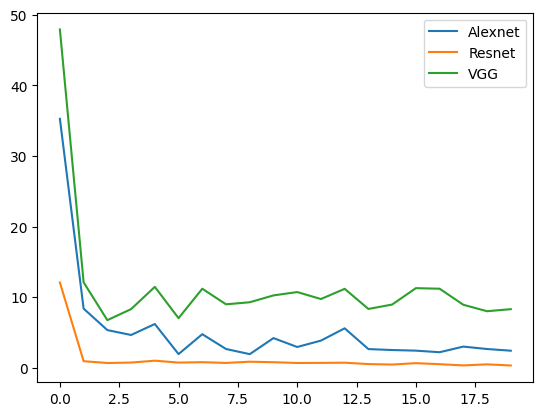

In [46]:
import matplotlib.pyplot as plt

plt.plot(range(epoch), alex_train_loss, label="Alexnet")
plt.plot(range(epoch), res_train_loss, label="Resnet")
plt.plot(range(epoch), vgg_train_loss, label="VGG")
plt.legend()

### change n_factor(k)

In [50]:
K = 40
# D = 20

# reg_theta = 0.1
# reg_beta = 0.1
# reg_e = 0


In [51]:
vbpr_alex = VBPR(n_user, n_item, K, D, F, feat_map_alex)
optimizer = Adam(params = vbpr_alex.parameters(), lr=lr)
alex_train_loss_40 = []

for i in range(epoch):
    alex_train_loss_40.append(train(vbpr_alex, optimizer, train_dataloader, criterion, device))
    print(f'EPOCH : {i} | LOSS : {alex_train_loss_40[-1]:.10}')

print("--------------------------------------------------------------------")

vbpr_res = VBPR(n_user, n_item, K, D, F_res, feat_map_res)
optimizer = Adam(params = vbpr_res.parameters(), lr=lr)
res_train_loss_40 = []

for i in range(epoch):
    res_train_loss_40.append(train(vbpr_res, optimizer, train_dataloader, criterion, device))
    print(f'EPOCH : {i} | LOSS : {res_train_loss_40[-1]:.10}')

print("--------------------------------------------------------------------")

vbpr_vgg = VBPR(n_user, n_item, K, D, F, feat_map_vgg)
optimizer = Adam(params = vbpr_vgg.parameters(), lr=lr)
vgg_train_loss_40 = []

for i in range(epoch):
    vgg_train_loss_40.append(train(vbpr_vgg, optimizer, train_dataloader, criterion, device))
    print(f'EPOCH : {i} | LOSS : {vgg_train_loss_40[-1]:.10}')

100%|██████████| 2055/2055 [00:24<00:00, 84.22it/s]


EPOCH : 0 | LOSS : 28.18210384


100%|██████████| 2055/2055 [00:24<00:00, 82.48it/s]


EPOCH : 1 | LOSS : 7.046804023


100%|██████████| 2055/2055 [00:24<00:00, 84.35it/s]


EPOCH : 2 | LOSS : 4.428007555


100%|██████████| 2055/2055 [00:24<00:00, 84.38it/s]


EPOCH : 3 | LOSS : 7.956360625


100%|██████████| 2055/2055 [00:24<00:00, 82.77it/s]


EPOCH : 4 | LOSS : 2.868613842


100%|██████████| 2055/2055 [00:23<00:00, 86.16it/s]


EPOCH : 5 | LOSS : 2.814103955


100%|██████████| 2055/2055 [00:23<00:00, 86.16it/s]


EPOCH : 6 | LOSS : 8.579558687


100%|██████████| 2055/2055 [00:23<00:00, 86.20it/s]


EPOCH : 7 | LOSS : 2.964048634


100%|██████████| 2055/2055 [00:23<00:00, 86.21it/s]


EPOCH : 8 | LOSS : 3.686908787


100%|██████████| 2055/2055 [00:23<00:00, 86.06it/s]


EPOCH : 9 | LOSS : 2.994235508


100%|██████████| 2055/2055 [00:24<00:00, 84.28it/s]


EPOCH : 10 | LOSS : 2.789032084


100%|██████████| 2055/2055 [00:24<00:00, 84.45it/s]


EPOCH : 11 | LOSS : 3.615923688


100%|██████████| 2055/2055 [00:25<00:00, 79.82it/s]


EPOCH : 12 | LOSS : 6.103832317


100%|██████████| 2055/2055 [00:24<00:00, 83.74it/s]


EPOCH : 13 | LOSS : 2.558734805


100%|██████████| 2055/2055 [00:24<00:00, 83.85it/s]


EPOCH : 14 | LOSS : 2.088150819


100%|██████████| 2055/2055 [00:23<00:00, 85.90it/s]


EPOCH : 15 | LOSS : 1.993634929


100%|██████████| 2055/2055 [00:23<00:00, 86.45it/s]


EPOCH : 16 | LOSS : 3.095410129


100%|██████████| 2055/2055 [00:24<00:00, 84.56it/s]


EPOCH : 17 | LOSS : 2.360050931


100%|██████████| 2055/2055 [00:26<00:00, 78.82it/s]


EPOCH : 18 | LOSS : 2.04970236


100%|██████████| 2055/2055 [00:24<00:00, 84.44it/s]


EPOCH : 19 | LOSS : 2.348759699
--------------------------------------------------------------------


100%|██████████| 2055/2055 [00:16<00:00, 125.82it/s]


EPOCH : 0 | LOSS : 10.98272017


100%|██████████| 2055/2055 [00:16<00:00, 126.33it/s]


EPOCH : 1 | LOSS : 0.9296352961


100%|██████████| 2055/2055 [00:16<00:00, 124.65it/s]


EPOCH : 2 | LOSS : 0.7893494078


100%|██████████| 2055/2055 [00:16<00:00, 122.07it/s]


EPOCH : 3 | LOSS : 1.000911919


100%|██████████| 2055/2055 [00:16<00:00, 125.86it/s]


EPOCH : 4 | LOSS : 1.167948515


100%|██████████| 2055/2055 [00:16<00:00, 124.28it/s]


EPOCH : 5 | LOSS : 0.8235874394


100%|██████████| 2055/2055 [00:17<00:00, 120.10it/s]


EPOCH : 6 | LOSS : 0.9123857598


100%|██████████| 2055/2055 [00:16<00:00, 122.40it/s]


EPOCH : 7 | LOSS : 0.7872915809


100%|██████████| 2055/2055 [00:16<00:00, 125.64it/s]


EPOCH : 8 | LOSS : 0.735302651


100%|██████████| 2055/2055 [00:16<00:00, 125.02it/s]


EPOCH : 9 | LOSS : 0.9112764455


100%|██████████| 2055/2055 [00:16<00:00, 126.80it/s]


EPOCH : 10 | LOSS : 0.7521344983


100%|██████████| 2055/2055 [00:16<00:00, 126.94it/s]


EPOCH : 11 | LOSS : 0.6108194673


100%|██████████| 2055/2055 [00:16<00:00, 123.63it/s]


EPOCH : 12 | LOSS : 0.5387842943


100%|██████████| 2055/2055 [00:17<00:00, 120.85it/s]


EPOCH : 13 | LOSS : 0.9015949113


100%|██████████| 2055/2055 [00:17<00:00, 120.64it/s]


EPOCH : 14 | LOSS : 0.4204573612


100%|██████████| 2055/2055 [00:16<00:00, 121.19it/s]


EPOCH : 15 | LOSS : 0.5046210329


100%|██████████| 2055/2055 [00:17<00:00, 116.90it/s]


EPOCH : 16 | LOSS : 0.6513782719


100%|██████████| 2055/2055 [00:17<00:00, 118.09it/s]


EPOCH : 17 | LOSS : 0.4889759619


100%|██████████| 2055/2055 [00:17<00:00, 120.19it/s]


EPOCH : 18 | LOSS : 0.4544509858


100%|██████████| 2055/2055 [00:17<00:00, 118.30it/s]


EPOCH : 19 | LOSS : 0.3908704371
--------------------------------------------------------------------


100%|██████████| 2055/2055 [00:23<00:00, 87.44it/s]


EPOCH : 0 | LOSS : 37.55897907


100%|██████████| 2055/2055 [00:23<00:00, 88.82it/s]


EPOCH : 1 | LOSS : 9.016051165


100%|██████████| 2055/2055 [00:23<00:00, 87.98it/s]


EPOCH : 2 | LOSS : 7.779947816


100%|██████████| 2055/2055 [00:23<00:00, 88.83it/s]


EPOCH : 3 | LOSS : 7.482064555


100%|██████████| 2055/2055 [00:23<00:00, 88.72it/s]


EPOCH : 4 | LOSS : 12.10761968


100%|██████████| 2055/2055 [00:23<00:00, 86.40it/s]


EPOCH : 5 | LOSS : 11.40450947


100%|██████████| 2055/2055 [00:24<00:00, 84.03it/s]


EPOCH : 6 | LOSS : 10.24837937


100%|██████████| 2055/2055 [00:25<00:00, 80.52it/s]


EPOCH : 7 | LOSS : 9.116939221


100%|██████████| 2055/2055 [00:23<00:00, 85.76it/s]


EPOCH : 8 | LOSS : 13.39221242


100%|██████████| 2055/2055 [00:23<00:00, 88.43it/s]


EPOCH : 9 | LOSS : 8.56362654


100%|██████████| 2055/2055 [00:23<00:00, 88.55it/s]


EPOCH : 10 | LOSS : 12.17954752


100%|██████████| 2055/2055 [00:23<00:00, 88.59it/s]


EPOCH : 11 | LOSS : 9.938569797


100%|██████████| 2055/2055 [00:23<00:00, 88.34it/s]


EPOCH : 12 | LOSS : 13.55961507


100%|██████████| 2055/2055 [00:23<00:00, 88.53it/s]


EPOCH : 13 | LOSS : 10.46487571


100%|██████████| 2055/2055 [00:23<00:00, 88.50it/s]


EPOCH : 14 | LOSS : 9.530770193


100%|██████████| 2055/2055 [00:23<00:00, 88.23it/s]


EPOCH : 15 | LOSS : 9.012995173


100%|██████████| 2055/2055 [00:23<00:00, 88.55it/s]


EPOCH : 16 | LOSS : 10.63092894


100%|██████████| 2055/2055 [00:23<00:00, 88.35it/s]


EPOCH : 17 | LOSS : 8.406587514


100%|██████████| 2055/2055 [00:23<00:00, 88.52it/s]


EPOCH : 18 | LOSS : 10.70024191


100%|██████████| 2055/2055 [00:23<00:00, 88.67it/s]

EPOCH : 19 | LOSS : 10.51508709


### Top K rec test

In [110]:
class Recommender:
    def __init__(self, model, query_img, train_dataset, n_item, feature_map, device) -> None:
        self.model = model
        self.train_df = train_dataset.dataset.df
        self.all_item = set(range(0,n_item))
        self.query_img = query_img
        self.feature_map = feature_map
        self.device = device

    def _get_img_sim(self, itemset:list):
        print("GET IMG SIM")
        res = []
        for item in itemset:
            res.append(nn.functional.cosine_similarity(self.query_img, self.feature_map[item.item()]))
        return res

    def _get_unobs_items(self, user_idx):
        obs_item_set = set(self.train_df[self.train_df.user_id==user_idx].isbn)
        return list(self.all_item - obs_item_set)

    def user_rank(self, user_idx:int, top_k:int=None):
        self.model.eval()
        unobs_itemset = self._get_unobs_items(user_idx)

        with torch.no_grad():
            itemset = torch.tensor(unobs_itemset).to(self.device)
            user = torch.tensor(np.full(len(itemset), user_idx)).to(self.device)
            img_sim = torch.tensor(self._get_img_sim(itemset))

            out, _ = self.model.cal_each(user, itemset)
            out = out + img_sim
            scores = np.array(torch.concat((user.unsqueeze(dim=1),itemset.unsqueeze(dim=1),out.unsqueeze(dim=1)), dim=1))
       
        sorted_scores = scores[(-scores[:, 2]).argsort()]
        return sorted_scores[:top_k]

In [116]:
def eval(recommender, test_dataset):
    df = test_dataset.dataset.df
    user_list = df['user_id'].unique()
    res_true = {}
    res_topk = {}
    res_hit = {}
    
    for user in tqdm(user_list[:50]):
        true_item = df[df.user_id==user].isbn
        if len(true_item)>4:
            res = recommender.user_rank(user, 20)
            topk = res[:,1]
            hit = len(set(true_item).intersection(set(topk)))
            res_true[user] = list(true_item)
            res_topk[user] = list(topk)
            res_hit[user] = hit
    
    return res_true, res_topk, res_hit

In [117]:
query_isbn = "0440234743"
img = prepare_img(query_isbn)
query = model_res(img)
# res = img_sim(query, feat_map_vgg)
# res
recommender = Recommender(vbpr_res, query, train_dataset, n_item, feat_map_res, device)

res_true, res_topk, res_hit = eval(recommender, test_dataset)

  0%|          | 0/50 [00:00<?, ?it/s]

GET IMG SIM


  4%|▍         | 2/50 [01:21<32:34, 40.73s/it]

GET IMG SIM


  6%|▌         | 3/50 [02:42<45:02, 57.51s/it]

GET IMG SIM


 12%|█▏        | 6/50 [04:03<27:51, 37.99s/it]

GET IMG SIM


 14%|█▍        | 7/50 [05:24<34:25, 48.04s/it]

GET IMG SIM


 16%|█▌        | 8/50 [06:45<39:20, 56.20s/it]

GET IMG SIM


 20%|██        | 10/50 [08:06<33:04, 49.61s/it]

GET IMG SIM


 26%|██▌       | 13/50 [09:26<23:59, 38.91s/it]

GET IMG SIM


 30%|███       | 15/50 [10:47<22:59, 39.40s/it]

GET IMG SIM


 32%|███▏      | 16/50 [12:08<26:35, 46.92s/it]

GET IMG SIM


 38%|███▊      | 19/50 [13:29<19:44, 38.21s/it]

GET IMG SIM


 40%|████      | 20/50 [14:50<22:48, 45.61s/it]

GET IMG SIM


 42%|████▏     | 21/50 [16:11<25:25, 52.61s/it]

GET IMG SIM


 44%|████▍     | 22/50 [17:32<27:27, 58.82s/it]

GET IMG SIM


 50%|█████     | 25/50 [18:27<16:18, 39.15s/it]

GET IMG SIM


 58%|█████▊    | 29/50 [19:14<09:05, 25.99s/it]

GET IMG SIM


 60%|██████    | 30/50 [20:01<09:42, 29.11s/it]

GET IMG SIM


 62%|██████▏   | 31/50 [20:49<10:12, 32.22s/it]

GET IMG SIM


 64%|██████▍   | 32/50 [21:36<10:33, 35.20s/it]

GET IMG SIM


 68%|██████▊   | 34/50 [22:23<08:15, 30.99s/it]

GET IMG SIM


 70%|███████   | 35/50 [23:12<08:40, 34.72s/it]

GET IMG SIM


 78%|███████▊  | 39/50 [24:04<04:13, 23.02s/it]

GET IMG SIM


 82%|████████▏ | 41/50 [24:55<03:33, 23.74s/it]

GET IMG SIM


 86%|████████▌ | 43/50 [25:47<02:50, 24.32s/it]

GET IMG SIM


 90%|█████████ | 45/50 [26:38<02:03, 24.71s/it]

GET IMG SIM


 94%|█████████▍| 47/50 [27:29<01:14, 24.95s/it]

GET IMG SIM


 96%|█████████▌| 48/50 [28:20<00:58, 29.44s/it]

GET IMG SIM


 98%|█████████▊| 49/50 [29:13<00:34, 34.03s/it]

GET IMG SIM


100%|██████████| 50/50 [30:06<00:00, 36.12s/it]
